In [12]:
# init

import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, decomposition, manifold
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from scipy.misc import imresize
from skimage import feature

init:
done


In [35]:
# load data

data_train = pickle.load(open("./data/data-train.pkl", 'rb'))
print("training set (%i samples)" % data_train['rgb'].shape[0])
data_test = pickle.load(open("./data/data-test.pkl", 'rb'))
print("test set (%i samples)" % data_test['rgb'].shape[0])

training set (38000 samples)
test set (8190 samples)


In [45]:
# plot helper

def plot(imgs):
    # make sure input is a list
    if not isinstance(imgs, list):
        imgs = [imgs]
        
    plt.figure()
    for i in range(len(imgs)):
        plt.subplot(1, len(imgs), i+1)
        plt.axis("off")
        plt.imshow(imgs[i])

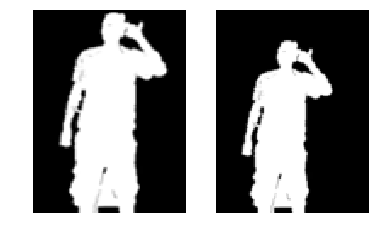

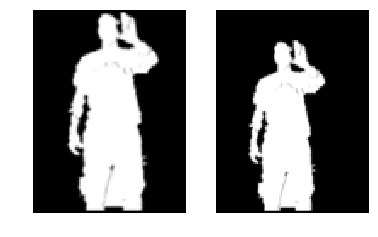

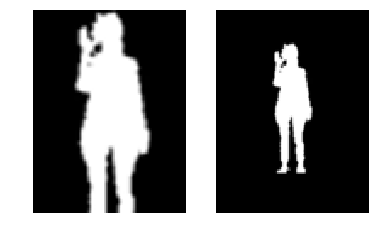

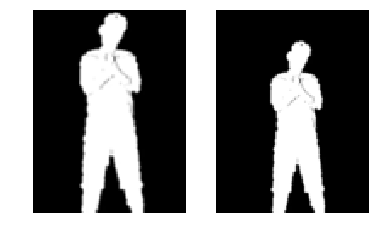

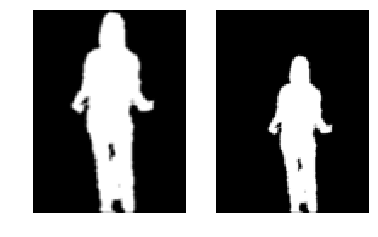

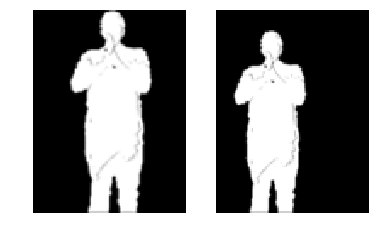

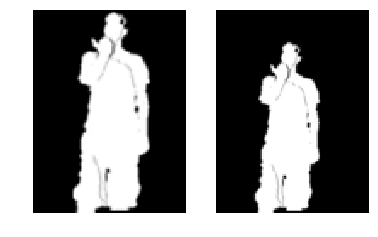

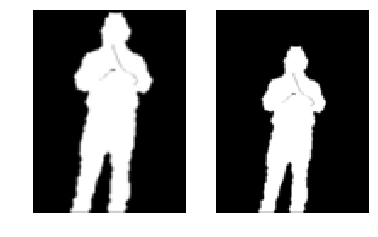

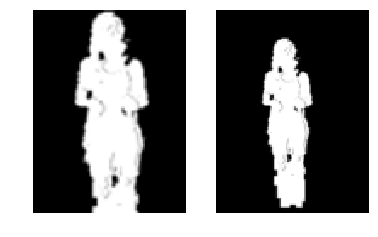

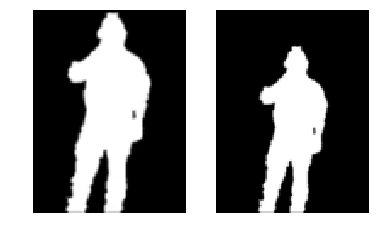

In [51]:
# crop and scale

for i in range(10):
    sample = data_train['segmentation'][i][:, :, 0]
    
    top = np.min(np.nonzero(np.any(sample, axis=1)))

    bottom = 120
    if not np.any(sample[119, :]):
        bottom = np.max(np.nonzero(np.any(sample, axis=1)))
        bottom = top+int((bottom-top)*0.85)
    
    height = bottom-top
    width = int((bottom-top)*0.75)
    factor = 120/height
    
    colsum = np.sum(sample, axis=0)
    
    left = np.min(np.nonzero(colsum))
    right = np.max(np.nonzero(colsum))
    
    cumsum = np.cumsum(colsum[left:right])
    
    avg = left+(np.abs(cumsum-np.average(cumsum))).argmin()
    
    left = 45+avg-int(45/factor)
    right = 45+avg+int(45/factor)
    
    seg_tmp = data_train['segmentation'][i].copy()
    seg_tmp = np.lib.pad(seg_tmp, ((0, 0), (45, 45), (0, 0)), 'constant', constant_values=0)
    
    rgb_tmp = data_train['rgb'][i].copy()
    rgb_tmp = np.lib.pad(rgb_tmp, ((0, 0), (45, 45), (0, 0)), 'edge')
    
    dep_tmp = data_train['depth'][i].copy()
    dep_tmp = np.lib.pad(dep_tmp, ((0, 0), (45, 45)), 'edge')
    
    seg = cv2.resize(seg_tmp[top:bottom, left:right, :] ,(90, 120), interpolation=cv2.INTER_CUBIC)
    rgb = cv2.resize(rgb_tmp[top:bottom, left:right, :] ,(90, 120), interpolation=cv2.INTER_CUBIC)
    dep = cv2.resize(dep_tmp[top:bottom, left:right] ,(90, 120), interpolation=cv2.INTER_CUBIC)
    
    plot([seg, data_train['segmentation'][i]])
    

In [ ]:
# map

In [ ]:
# normalize depth